### This notebook is initial submission for the hackathon 

https://datahack.analyticsvidhya.com/contest/wns-analytics-wizard-2019/

My public and private leaderboard scores are 0.6372217923 and 0.6301590254 respectively

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [164]:
train_data = pd.read_csv('/Users/lavanyamk/Documents/WNS_hackathon/train_NA17Sgz/train.csv')

In [3]:
view_log = pd.read_csv('/Users/lavanyamk/Documents/WNS_hackathon/train_NA17Sgz/view_log.csv')

In [4]:
item_data = pd.read_csv('/Users/lavanyamk/Documents/WNS_hackathon/train_NA17Sgz/item_data.csv')

In [42]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 7 columns):
impression_id      237609 non-null object
impression_time    237609 non-null object
user_id            237609 non-null int64
app_code           237609 non-null int64
os_version         237609 non-null object
is_4G              237609 non-null int64
is_click           237609 non-null int64
dtypes: int64(4), object(3)
memory usage: 12.7+ MB


In [6]:
test_data = pd.read_csv('/Users/lavanyamk/Documents/WNS_hackathon/test.csv')

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90675 entries, 0 to 90674
Data columns (total 6 columns):
impression_id      90675 non-null object
impression_time    90675 non-null object
user_id            90675 non-null int64
app_code           90675 non-null int64
os_version         90675 non-null object
is_4G              90675 non-null int64
dtypes: int64(3), object(3)
memory usage: 4.2+ MB


In [9]:
pd.read_csv('/Users/lavanyamk/Documents/WNS_hackathon/sample_submission.csv').head(5)

,impression_id,is_click
0,a9e7126a585a69a32bc7414e9d0c0ada,0
1,caac14a5bf2ba283db7708bb34855760,0
2,13f10ba306a19ce7bec2f3cae507b698,0
3,39c4b4dc0e9701b55a0a4f072008fb3f,0
4,bf5a572cca75f5fc67f4b14e58b11d70,0


In [8]:
train_data.head(7)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0
5,3416a75f4cea9109507cacd8e2f2aefc,2018-11-15 00:03:00,67352,409,latest,1,0
6,f457c545a9ded88f18ecee47145a72c0,2018-11-15 00:03:00,64356,190,intermediate,0,0


In [35]:
train_data.app_code.nunique()

490

In [44]:
train_data.is_click.sum()

10862

In [46]:
train_data[train_data.is_click==1].shape

(10862, 7)

In [45]:
train_data.is_click.count()

237609

In [43]:
train_data.is_click.sum() / train_data.is_click.count()

0.04571375663379754

In [23]:
view_log.head(5)

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [24]:
item_data.head(5)

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [83]:
view_log.device_type.value_counts()

android    3117737
iphone         861
web             24
Name: device_type, dtype: int64

In [89]:
view_log.item_id.nunique()

126708

In [88]:
view_log.item_id.value_counts()[:10]

425       14821
72955     12930
33633     12711
64835     12008
118262    11816
127900    11102
84704      9182
76404      8838
119516     8761
95249      8745
Name: item_id, dtype: int64

In [603]:
item_data.shape

(132761, 6)

### Check whether data for all user_id exists in view_log table

In [66]:
view_log[view_log.user_id.isin(list((set(test_data.user_id) - set(train_data.user_id))))].head()

,server_time,device_type,session_id,user_id,item_id
40,2018-10-15 08:59:00,android,697157,76951,115384
45,2018-10-15 08:59:00,android,638275,25079,31638
55,2018-10-15 09:00:00,android,924466,66164,127900
56,2018-10-15 09:00:00,android,625057,30588,22047
57,2018-10-15 09:00:00,android,924466,66164,61874


In [64]:
view_log[view_log.user_id.isin(list((set(test_data.user_id) - set(train_data.user_id))))].user_id.nunique()

14434

In [69]:
view_log[view_log.user_id.isin(train_data.user_id)].user_id.nunique()

74723

In [73]:
view_log[view_log.user_id.isin(test_data.user_id)].user_id.nunique()

34079

In [48]:
view_log.shape

(3118622, 5)

In [49]:
test_data.shape

(90675, 6)

In [70]:
test_data.user_id.nunique()

34079

In [72]:
train_data.user_id.nunique()

74723

In [67]:
test_data[test_data.user_id.isin(list((set(test_data.user_id) - set(train_data.user_id))))].head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1
16,e48379e1edcf90e9cfc6bcac30d84151,2018-12-12 20:39:00,57286,504,latest,0
24,b28d65100de9473e159832d8fbfc08ce,2018-12-12 20:43:00,54670,296,old,0
27,3fa5327c0267ab516572d8eeffb7e56c,2018-12-12 20:44:00,62718,386,latest,0


In [68]:
test_data[test_data.user_id.isin(list((set(test_data.user_id) - set(train_data.user_id))))].user_id.nunique()

14434

In [47]:
view_log.user_id.nunique()

89157

In [17]:
train_data.shape

(237609, 7)

In [18]:
test_data.shape

(90675, 6)

## Click through rate based on os

In [22]:
train_data.groupby('os_version',as_index=False).agg(
{
    'is_click':['mean','sum','count']
}).rename(columns={'mean':'CTR','sum':'total_clicks'})

os_version  is_click                     
                      CTR total_clicks   count
0  intermediate  0.051762         2875   55543
1        latest  0.041651         5382  129216
2           old  0.049290         2605   52850

In [26]:
ctr_per_os = train_data.groupby('os_version',as_index=False).agg(
{
    'is_click':['mean','sum','count']
}).rename(columns={'mean':'CTR','sum':'total_clicks'})

In [149]:
ctr_per_os = pd.DataFrame(ctr_per_os.values, columns=['os_version','ctr_os','total_clicks','click_count_os'])

In [150]:
ctr_per_os.head()
    

,os_version,ctr_os,total_clicks,click_count_os
0,intermediate,0.0517617,2875,55543
1,latest,0.0416512,5382,129216
2,old,0.0492904,2605,52850


## Click through rate based on app code

In [157]:
set(test_data.app_code)-set(train_data.app_code)#.nunique()

{10,
 11,
 18,
 33,
 56,
 94,
 103,
 134,
 136,
 146,
 148,
 155,
 167,
 219,
 227,
 232,
 245,
 282,
 304,
 324,
 339,
 357,
 387,
 402,
 413,
 433,
 456,
 460,
 490,
 494,
 501,
 511}

In [37]:
ctr_app_code = train_data.groupby('app_code',as_index=False).agg({
    'is_click':['mean','sum','count']
}).rename(columns={'mean':'CTR','sum':'total_clicks'})
ctr_app_code.columns = ["_".join(x) for x in ctr_app_code.columns.ravel()]

In [41]:
ctr_app_code[ctr_app_code.is_click_CTR>=0.2]

,app_code_,is_click_CTR,is_click_total_clicks,is_click_count
25,28,0.500000,1,2
41,45,0.500000,1,2
45,49,0.200000,3,15
46,50,0.223108,56,251
50,54,0.500000,1,2
55,60,1.000000,1,1
57,62,0.230769,3,13
80,85,1.000000,1,1
83,88,0.333333,1,3
97,104,0.333333,1,3


## Click through rate based on Item

In [37]:
ctr_app_code = train_data.groupby('app_code',as_index=False).agg({
    'is_click':['mean','sum','count']
}).rename(columns={'mean':'CTR','sum':'total_clicks'})
ctr_app_code.columns = ["_".join(x) for x in ctr_app_code.columns.ravel()]

In [23]:
view_log.head(5)

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


## Clicks based on user activity

In [27]:
train_data.user_id.nunique()

74723

In [119]:
train_on_user = train_data.groupby(['user_id'],as_index=False).agg(
{
    'is_click':['sum','count']
})

In [120]:
list(train_on_user.columns.to_frame(index = False)[0]+"_"+train_on_user.columns.to_frame(index = False)[1])

['user_id_', 'is_click_sum', 'is_click_count']

In [121]:
train_on_user = pd.DataFrame(train_on_user.values,columns=list(train_on_user.columns.to_frame(index = False)[0]+"_"+train_on_user.columns.to_frame(index = False)[1]))

In [122]:
train_on_user.head()

,user_id_,is_click_sum,is_click_count
0,0,0,1
1,2,0,4
2,3,0,1
3,5,0,2
4,6,0,1


In [123]:
train_on_user['is_click_sum'].value_counts()

0     67067
1      5886
2      1089
3       361
4       152
5        71
6        45
7        16
9        10
8         7
11        6
10        5
15        3
12        3
14        1
13        1
Name: is_click_sum, dtype: int64

In [125]:
train_on_user['is_click_count'].value_counts()[0:9]

1    34093
2    17274
3     6509
4     4611
5     2504
6     1925
7     1235
8     1128
9      768
Name: is_click_count, dtype: int64

In [127]:
train_on_user[train_on_user.is_click_sum==13]

,user_id_,is_click_sum,is_click_count
63786,79033,13,19


In [293]:
train_on_user.columns

Index(['user_id_', 'is_click_sum', 'is_click_count'], dtype='object')

In [294]:
train_on_user.columns =['user_id', 'is_click_sum', 'is_click_count'] 

## Let's build initial model!!

Let's check Time distribution 

In [180]:
train_data.impression_time = pd.to_datetime(train_data.impression_time)
test_data.impression_time = pd.to_datetime(test_data.impression_time)

In [166]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 7 columns):
impression_id      237609 non-null object
impression_time    237609 non-null datetime64[ns]
user_id            237609 non-null int64
app_code           237609 non-null int64
os_version         237609 non-null object
is_4G              237609 non-null int64
is_click           237609 non-null int64
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 12.7+ MB


In [169]:
train_data.impression_time.describe()

count                  237609
unique                  36461
top       2018-12-04 00:01:00
freq                       46
first     2018-11-15 00:00:00
last      2018-12-13 07:43:00
Name: impression_time, dtype: object

In [174]:
train_data['impression_time'].dt.hour.describe()

count    237609.000000
mean         13.451271
std           7.161339
min           0.000000
25%           9.000000
50%          15.000000
75%          19.000000
max          23.000000
Name: impression_time, dtype: float64

In [177]:
train_data['impression_time'].dt.hour.value_counts()
#more people seeing impression at 12 AM, Hmmmm.. interesting!!

0     21211
20    15386
21    15297
22    14526
19    13992
17    13794
18    13749
23    12978
16    12932
15    11945
14    11077
1     10769
13    10263
12     9776
11     9553
10     8975
9      8328
8      6088
7      5075
2      4703
6      3098
5      1589
3      1346
4      1159
Name: impression_time, dtype: int64

In [186]:
train_data['impression_time'].dt.dayofweek.value_counts()
#more people seeing impression at 12 AM, Hmmmm.. interesting!!

1    43946
0    34948
3    33989
6    31682
5    31306
4    30941
2    30797
Name: impression_time, dtype: int64

In [179]:
pd.to_datetime(test_data['impression_time']).dt.hour.value_counts()

0     7623
21    5140
18    5021
20    4985
17    4924
22    4885
16    4822
19    4797
23    4577
15    4274
14    4148
12    4108
11    4007
13    3990
10    3953
9     3946
1     3476
8     3443
7     2959
6     1639
2     1599
5      943
3      793
4      623
Name: impression_time, dtype: int64

In [353]:
def split_date(dataframe,date_col):
    dataframe['hour'] = dataframe[date_col].dt.hour
    dataframe['dayofweek'] = dataframe[date_col].dt.dayofweek
    dataframe['dayofmonth'] = dataframe[date_col].dt.day
    return dataframe

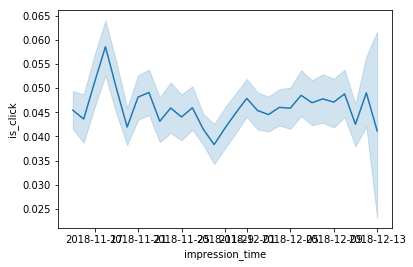

In [206]:
sns.lineplot(train_data['impression_time'].dt.date,train_data['is_click'])

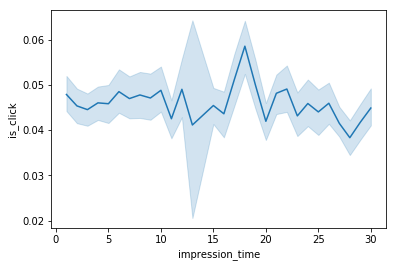

In [209]:
sns.lineplot(train_data['impression_time'].dt.day,train_data['is_click'])

In [211]:
train_data['impression_time'].dt.day.unique()

array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [354]:
split_date(train_data,'impression_time').head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,hour,dayofweek,dayofmonth
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0,3,15
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,0,3,15
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,0,3,15
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,0,3,15
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,0,3,15


In [355]:
split_date(test_data,'impression_time').head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,hour,dayofweek,dayofmonth
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1,7,3,13
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,7,3,13
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1,7,3,13
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1,7,3,13
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1,7,3,13


In [214]:
train_data.groupby('hour',as_index=False).agg({
    'is_click':['mean','sum','count']
}).rename(columns={'mean':'CTR','sum':'total_clicks'})

hour  is_click                    
              CTR total_clicks  count
0     0  0.045731          970  21211
1     1  0.048101          518  10769
2     2  0.046141          217   4703
3     3  0.058692           79   1346
4     4  0.055220           64   1159
5     5  0.046570           74   1589
6     6  0.039703          123   3098
7     7  0.039409          200   5075
8     8  0.043200          263   6088
9     9  0.040466          337   8328
10   10  0.040223          361   8975
11   11  0.048885          467   9553
12   12  0.045110          441   9776
13   13  0.037903          389  10263
14   14  0.044055          488  11077
15   15  0.044370          530  11945
16   16  0.042994          556  12932
17   17  0.049514          683  13794
18   18  0.044512          612  13749
19   19  0.049028          686  13992
20   20  0.048096          740  15386
21   21  0.051317          785  15297
22   22  0.046055          669  14526
23   23  0.047003          610  12978

In [216]:
hour_level_ctr_temp = train_data.groupby('hour',as_index=False).agg({
    'is_click':['mean','sum','count']
}).rename(columns={'mean':'CTR','sum':'total_clicks'})

In [218]:
hour_level_ctr = pd.DataFrame(hour_level_ctr_temp.values,columns=['hour','ctr_hour','clicks_sum_hour','total_clicks_per_hour'])

In [219]:
train_data.groupby('dayofweek',as_index=False).agg({
    'is_click':['mean','sum','count']
}).rename(columns={'mean':'CTR','sum':'total_clicks'})

dayofweek  is_click                    
                  CTR total_clicks  count
0         0  0.046698         1632  34948
1         1  0.043007         1890  43946
2         2  0.044517         1371  30797
3         3  0.045868         1559  33989
4         4  0.044730         1384  30941
5         5  0.048106         1506  31306
6         6  0.047977         1520  31682

In [243]:
ctr_app_code.columns =['app_code', 'ctr_app', 'app_total_clicks', 'app_click_count']

In [244]:
ctr_app_code.head()

,app_code,ctr_app,app_total_clicks,app_click_count
0,0,0.082192,6,73
1,1,0.085714,3,35
2,2,0.067164,9,134
3,3,0.034424,305,8860
4,4,0.000000,0,2


In [245]:
train_data.head(2)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,hour,dayofweek,dayofmonth
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0,3,15
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,0,3,15


In [356]:
train_feat = train_data.merge(ctr_app_code,on='app_code',how='left')

In [357]:
test_feat = test_data.merge(ctr_app_code,on='app_code',how='left')

In [358]:
test_feat.info()#.fillna(0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90675 entries, 0 to 90674
Data columns (total 12 columns):
impression_id       90675 non-null object
impression_time     90675 non-null datetime64[ns]
user_id             90675 non-null int64
app_code            90675 non-null int64
os_version          90675 non-null object
is_4G               90675 non-null int64
hour                90675 non-null int64
dayofweek           90675 non-null int64
dayofmonth          90675 non-null int64
ctr_app             90620 non-null float64
app_total_clicks    90620 non-null float64
app_click_count     90620 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(6), object(2)
memory usage: 9.0+ MB


In [359]:
train_feat = train_feat.merge(ctr_per_os,on='os_version',how='left')

In [360]:
test_feat = test_feat.merge(ctr_per_os,on='os_version',how='left')

In [361]:
ctr_per_os.head(2)#train_feat.

,os_version,ctr_os,total_clicks_os,click_count_os
0,intermediate,0.0517617,2875,55543
1,latest,0.0416512,5382,129216


In [362]:
ctr_per_os.columns = ['os_version', 'ctr_os', 'total_clicks_os', 'click_count_os']

In [363]:
ctr_per_os.head(2)#train_feat.

,os_version,ctr_os,total_clicks_os,click_count_os
0,intermediate,0.0517617,2875,55543
1,latest,0.0416512,5382,129216


In [364]:
hour_level_ctr.head(1)

,hour,ctr_hour,clicks_sum_hour,total_clicks_per_hour
0,0.0,0.045731,970.0,21211.0


In [365]:
train_feat =train_feat.merge(hour_level_ctr,on='hour',how='left')

In [366]:
test_feat =test_feat.merge(hour_level_ctr,on='hour',how='left')

In [367]:
train_feat = train_feat.merge(train_on_user,on='user_id',how='left')

In [368]:
#test_feat = 
test_feat.merge(train_on_user,on='user_id',how='left').is_click_sum.isnull().value_counts()#.fillna(0)

False    66877
True     23798
Name: is_click_sum, dtype: int64

In [369]:
test_feat = test_feat.merge(train_on_user,on='user_id',how='left').fillna(0)

In [370]:
train_feat.shape

(237609, 21)

In [371]:
train_feat.columns

Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G', 'is_click', 'hour', 'dayofweek', 'dayofmonth', 'ctr_app',
       'app_total_clicks', 'app_click_count', 'ctr_os', 'total_clicks_os',
       'click_count_os', 'ctr_hour', 'clicks_sum_hour',
       'total_clicks_per_hour', 'is_click_sum', 'is_click_count'],
      dtype='object')

In [374]:
train_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237609 entries, 0 to 237608
Data columns (total 21 columns):
impression_id            237609 non-null object
impression_time          237609 non-null datetime64[ns]
user_id                  237609 non-null int64
app_code                 237609 non-null int64
os_version               237609 non-null object
is_4G                    237609 non-null int64
is_click                 237609 non-null int64
hour                     237609 non-null int64
dayofweek                237609 non-null int64
dayofmonth               237609 non-null int64
ctr_app                  237609 non-null float64
app_total_clicks         237609 non-null int64
app_click_count          237609 non-null int64
ctr_os                   237609 non-null object
total_clicks_os          237609 non-null object
click_count_os           237609 non-null object
ctr_hour                 237609 non-null float64
clicks_sum_hour          237609 non-null float64
total_clicks_per_hour  

In [372]:
test_feat.shape

(90675, 20)

In [373]:
test_feat.columns

Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G', 'hour', 'dayofweek', 'dayofmonth', 'ctr_app',
       'app_total_clicks', 'app_click_count', 'ctr_os', 'total_clicks_os',
       'click_count_os', 'ctr_hour', 'clicks_sum_hour',
       'total_clicks_per_hour', 'is_click_sum', 'is_click_count'],
      dtype='object')

In [375]:
test_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90675 entries, 0 to 90674
Data columns (total 20 columns):
impression_id            90675 non-null object
impression_time          90675 non-null datetime64[ns]
user_id                  90675 non-null int64
app_code                 90675 non-null int64
os_version               90675 non-null object
is_4G                    90675 non-null int64
hour                     90675 non-null int64
dayofweek                90675 non-null int64
dayofmonth               90675 non-null int64
ctr_app                  90675 non-null float64
app_total_clicks         90675 non-null float64
app_click_count          90675 non-null float64
ctr_os                   90675 non-null float64
total_clicks_os          90675 non-null int64
click_count_os           90675 non-null int64
ctr_hour                 90675 non-null float64
clicks_sum_hour          90675 non-null float64
total_clicks_per_hour    90675 non-null float64
is_click_sum             90675 non-nul

Patterns of view logs and item data

In [142]:
item_data.shape

(132761, 6)

In [257]:
view_log.shape

(3118622, 5)

In [253]:
view_log.tail(2)

,server_time,device_type,session_id,user_id,item_id
3118620,2018-12-11 23:59:00,android,601193,16870,38284
3118621,2018-12-11 23:59:00,android,138217,1007,88331


In [267]:
user_item_log = view_log.groupby('user_id',as_index=False).agg(
    {'item_id':['count','nunique']})
user_item_log.columns= ['user_id','item_count','unique_item_count']

In [252]:
item_data.tail(2)

,item_id,item_price,category_1,category_2,category_3,product_type
132759,93041,11673,17,39,252,2874
132760,104247,229632,4,38,62,4933


In [268]:
user_item_log.head()

,user_id,item_count,unique_item_count
0,0,42,18
1,1,8,8
2,2,165,130
3,3,8,3
4,4,2,2


In [285]:
train_feat = train_feat.merge(user_item_log,on='user_id',how='left')
test_feat = test_feat.merge(user_item_log,on='user_id',how='left')

In [269]:
dir()[-25:]

['_iii',
 '_oh',
 'ctr_app_code',
 'ctr_per_os',
 'exit',
 'get_ipython',
 'hour_ctr',
 'hour_level_ctr',
 'hour_level_ctr_temp',
 'item_data',
 'lgbm',
 'np',
 'pd',
 'plt',
 'quit',
 'register_matplotlib_converters',
 'sns',
 'split_date',
 'test_data',
 'test_feat',
 'train_data',
 'train_feat',
 'train_on_user',
 'user_item_log',
 'view_log']

In [288]:
train_feat.head(2)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,hour,dayofweek,dayofmonth,...,app_total_clicks,app_click_count,ctr_os,total_clicks_os,click_count_os,ctr_hour,clicks_sum_hour,total_clicks_per_hour,item_count,unique_item_count
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0,3,15,...,58,395,0.0492904,2605,52850,0.045731,970.0,21211.0,1,1
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,0,3,15,...,26,422,0.0416512,5382,129216,0.045731,970.0,21211.0,12,7


In [378]:
test_feat.os_version.unique()

array(['latest', 'old', 'intermediate'], dtype=object)

In [396]:
 total_app_codes = list(set(train_data.app_code.unique()) | set(test_data.app_code.unique()))

In [397]:
len(total_app_codes)

522

In [398]:
train_feat.app_code.nunique()

490

In [574]:
train_feat.to_csv('train_features.csv',index=False)
test_feat.to_csv('test_features.csv',index=False)

In [433]:
#train_temp = 
train_tmp = pd.concat([train_feat,pd.get_dummies(train_feat.os_version)],axis=1)
test_tmp = pd.concat([test_feat,pd.get_dummies(test_feat.os_version)],axis=1)

In [434]:
train_tmp.head(2)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,hour,dayofweek,dayofmonth,...,total_clicks_os,click_count_os,ctr_hour,clicks_sum_hour,total_clicks_per_hour,is_click_sum,is_click_count,intermediate,latest,old
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0,3,15,...,2605,52850,0.045731,970.0,21211.0,0,3,0,0,1
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,0,3,15,...,5382,129216,0.045731,970.0,21211.0,5,52,0,1,0


In [435]:
train_tmp.shape

(237609, 24)

In [436]:
train_tmp.total_clicks_os = train_tmp.total_clicks_os.astype(float)
train_tmp.click_count_os = train_tmp.click_count_os.astype(float)
train_tmp.ctr_os = train_tmp.ctr_os.astype(float)

In [437]:
train_tmp.columns

Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G', 'is_click', 'hour', 'dayofweek', 'dayofmonth', 'ctr_app',
       'app_total_clicks', 'app_click_count', 'ctr_os', 'total_clicks_os',
       'click_count_os', 'ctr_hour', 'clicks_sum_hour',
       'total_clicks_per_hour', 'is_click_sum', 'is_click_count',
       'intermediate', 'latest', 'old'],
      dtype='object')

In [438]:
train_tmp = train_tmp.drop(columns=['impression_id', 'impression_time', 'user_id','os_version','is_click'])

In [439]:
test_tmp = test_tmp.drop(columns=['impression_id', 'impression_time', 'user_id','os_version'])

In [440]:
train_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237609 entries, 0 to 237608
Data columns (total 19 columns):
app_code                 237609 non-null int64
is_4G                    237609 non-null int64
hour                     237609 non-null int64
dayofweek                237609 non-null int64
dayofmonth               237609 non-null int64
ctr_app                  237609 non-null float64
app_total_clicks         237609 non-null int64
app_click_count          237609 non-null int64
ctr_os                   237609 non-null float64
total_clicks_os          237609 non-null float64
click_count_os           237609 non-null float64
ctr_hour                 237609 non-null float64
clicks_sum_hour          237609 non-null float64
total_clicks_per_hour    237609 non-null float64
is_click_sum             237609 non-null int64
is_click_count           237609 non-null int64
intermediate             237609 non-null uint8
latest                   237609 non-null uint8
old                      2376

In [443]:
#test_tmp[['app_total_clicks', 'app_click_count','is_click_count','is_click_sum']].astype(int).info()
test_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90675 entries, 0 to 90674
Data columns (total 19 columns):
app_code                 90675 non-null int64
is_4G                    90675 non-null int64
hour                     90675 non-null int64
dayofweek                90675 non-null int64
dayofmonth               90675 non-null int64
ctr_app                  90675 non-null float64
app_total_clicks         90675 non-null float64
app_click_count          90675 non-null float64
ctr_os                   90675 non-null float64
total_clicks_os          90675 non-null int64
click_count_os           90675 non-null int64
ctr_hour                 90675 non-null float64
clicks_sum_hour          90675 non-null float64
total_clicks_per_hour    90675 non-null float64
is_click_sum             90675 non-null float64
is_click_count           90675 non-null float64
intermediate             90675 non-null uint8
latest                   90675 non-null uint8
old                      90675 non-null uint8

In [445]:
X =  train_tmp.copy()

In [444]:
y = train_data['is_click']

In [446]:
X_val = test_tmp.copy()

In [447]:
from sklearn.model_selection import train_test_split

In [448]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [ ]:
lgbm.LGBMClassifier()

In [460]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [467]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [468]:
from sklearn.metrics import classification_report

In [487]:
def train_predict_print_report(est):
    est.fit(X_train, y_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, est.predict(X_test))
    print('AUC: {}'.format(auc(false_positive_rate, true_positive_rate)))
    print('ROC: {}'.format(roc_auc_score(y_test, est.predict(X_test))))
    print(classification_report(y_test, est.predict(X_test)))

In [492]:
lgbmc = lgbm.LGBMClassifier()
bgc = BaggingClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
rfc = RandomForestClassifier()
etc = ExtraTreesClassifier()

In [493]:
model_list = [lgbmc, bgc, abc, gbc, rfc, etc]

In [495]:
for clf in model_list:
    print(clf)
    train_predict_print_report(clf)
    print()
    print()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
AUC: 0.6345636468105771
ROC: 0.6345636468105771
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     74900
           1       0.71      0.27      0.40      3511

   micro avg       0.96      0.96      0.96     78411
   macro avg       0.84      0.63      0.69     78411
weighted avg       0.96      0.96      0.95     78411



BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,

In [506]:
gbc1 = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.07, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=800,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [507]:
train_predict_print_report(gbc1)

AUC: 0.6377544919857067
ROC: 0.6377544919857067
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     74900
           1       0.64      0.28      0.39      3511

   micro avg       0.96      0.96      0.96     78411
   macro avg       0.81      0.64      0.69     78411
weighted avg       0.95      0.96      0.95     78411



In [563]:
lgc = lgbm.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        min_child_samples=60, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
        random_state=52, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [564]:
train_predict_print_report(lgc)

AUC: 0.6387580497532265
ROC: 0.6387580497532265
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     74900
           1       0.70      0.28      0.40      3511

   micro avg       0.96      0.96      0.96     78411
   macro avg       0.84      0.64      0.69     78411
weighted avg       0.96      0.96      0.95     78411



In [565]:
lgc.fit(X,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        min_child_samples=60, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
        random_state=52, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [602]:
pd.read_csv('/Users/lavanyamk/Documents/WNS_hackathon/sample_submission.csv').head(2)

0    90675
Name: is_click, dtype: int64

In [591]:
res = pd.DataFrame(lgc.predict_proba(X_val), columns=['zero','one'])

In [ ]:
res_pred = pd.DataFrame(lgc.predict(X_val), columns=[''])

In [600]:
res.loc[res.one>0.8,'one'].count()

506

In [601]:
pd.concat([test_data['impression_id'],pd.DataFrame({'is_click':lgc.predict_proba(X_val)[:,1]})],axis=1).to_csv('first_submission.csv',index=False)

In [483]:
y_probs = est.predict_proba(X_test)[:,1]
fp_rate, tp_rate, thresholds = roc_curve(y_test, y_probs)
auc(fp_rate, tp_rate)

y_pred = est.predict(X_test)
fp_rate, tp_rate, thresholds = roc_curve(y_test, y_pred)
print(auc(fp_rate, tp_rate))
# 0.857142857143

print(roc_auc_score(y_test, y_pred))
# 0.857142857143

0.6345636468105771
0.6345636468105771
